#### Attention ! C'est un sujet compliqué ! Rappelez-vous que c'est un notebook facultatif à parcourir et que pour le comprendre pleinement, vous devez lire les liens supplémentaires et regarder la vidéo explicative entièrement. Ce notebook et les vidéos liées n'ont pas pour but de donner un aperçu complet d'ARIMA, mais plutôt de vous montrer à quoi il peut servir, afin que vous puissiez comprendre plus tard pourquoi il peut être ou non un bon choix pour les données financières sur les actions.
____


# ARIMA et ARIMA Saisonnier


## Moyennes Mobiles Intégrées Auto-Régressives

Le processus général pour les modèles ARIMA est le suivant:
* Visualiser les données de la série temporelle
* Rendre les données de la série temporelle stationnaires
* Tracer les graphiques de corrélation et d'auto-corrélation
* Construire le modèle ARIMA
* Utiliser le modèle pour faire des prédictions

Passons par ces étapes !

## Étape 1: Obtenir les données (et les formatter)

Nous utiliserons quelques données sur la production laitière mensuelle.

C'est déjà enregistré en csv pour vous, chargeons le:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

Month  Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0  1962-01                                              589.0       
1  1962-02                                              561.0       
2  1962-03                                              640.0       
3  1962-04                                              656.0       
4  1962-05                                              727.0

In [4]:
df.tail()

Month  \
164                                            1975-09   
165                                            1975-10   
166                                            1975-11   
167                                            1975-12   
168  Monthly milk production: pounds per cow. Jan 6...   

     Monthly milk production: pounds per cow. Jan 62 ? Dec 75  
164                                              817.0         
165                                              827.0         
166                                              797.0         
167                                              843.0         
168                                                NaN

**Nettoyage**

Nettoyons un peu tout ça !

In [5]:
df.columns = ['Month','Milk in pounds per cow']
df.head()

Month  Milk in pounds per cow
0  1962-01                   589.0
1  1962-02                   561.0
2  1962-03                   640.0
3  1962-04                   656.0
4  1962-05                   727.0

In [6]:
# Dernière valeur bizarre en bas causant des problèmes
df.drop(168,axis=0,inplace=True)

In [7]:
df['Month'] = pd.to_datetime(df['Month'])

In [8]:
df.head()

Month  Milk in pounds per cow
0 1962-01-01                   589.0
1 1962-02-01                   561.0
2 1962-03-01                   640.0
3 1962-04-01                   656.0
4 1962-05-01                   727.0

In [9]:
df.set_index('Month',inplace=True)

In [10]:
df.head()

Milk in pounds per cow
Month                             
1962-01-01                   589.0
1962-02-01                   561.0
1962-03-01                   640.0
1962-04-01                   656.0
1962-05-01                   727.0

In [11]:
df.describe().transpose()

count        mean         std    min     25%    50%  \
Milk in pounds per cow  168.0  754.708333  102.204524  553.0  677.75  761.0   

                          75%    max  
Milk in pounds per cow  824.5  969.0

## Étape 2: Visualiser les données

Visualisons ces données avec quelques méthodes.

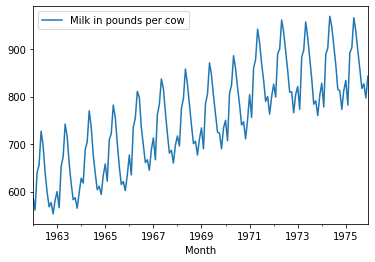

In [12]:
df.plot()

In [13]:
timeseries = df['Milk in pounds per cow']

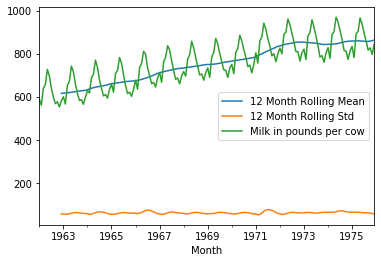

In [14]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

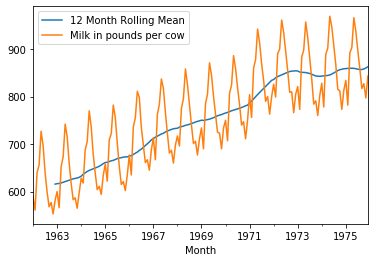

In [15]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Décomposition

La décomposition ETS nous permet de voir les différentes parties !

<Figure size 432x288 with 0 Axes>

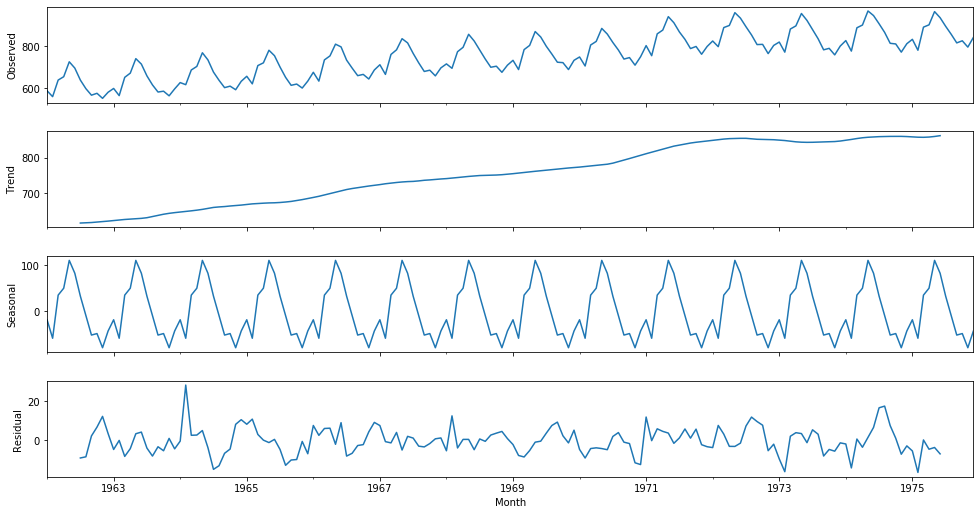

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Test pour la Stationnarité

Nous pouvons utiliser le test de [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) augmenté ([unit root test](https://en.wikipedia.org/wiki/Unit_root_test)).

En statistique et en économétrie, un test de Dickey-Fuller augmenté (ADF) permet de tester l'hypothèse nulle de la présence d'une racine unitaire dans un échantillon de série temporelle. L'hypothèse de rechange est différente selon la version du test utilisée, mais il s'agit habituellement de la stationnarité ou de la tendance-stationnarité.

Fondamentalement, nous essayons d'accepter l'hypothèse nulle **H0** (que la série temporelle a une racine unitaire, indiquant qu'elle est non stationnaire) ou de rejeter **H0** et d'opter pour l'hypothèse alternative (que la série temporelle n'a pas de racine unitaire et est stationnaire).

Nous finissons par décider cela en fonction du rendement de la valeur p.

* Une petite valeur p (typiquement ≤ 0,05) indique une forte évidence contre l'hypothèse nulle, donc vous rejetez l'hypothèse nulle.

* Une valeur p élevée (> 0,05) indique une faible preuve contre l'hypothèse nulle, donc vous ne pouvez pas rejeter l'hypothèse nulle.

Faisons le test du Dickey-Fuller Augmenté sur nos données :

In [17]:
df.head()

Milk in pounds per cow
Month                             
1962-01-01                   589.0
1962-02-01                   561.0
1962-03-01                   640.0
1962-04-01                   656.0
1962-05-01                   727.0

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
result = adfuller(df['Milk in pounds per cow'])

In [20]:
print('Augmented Dickey-Fuller test (DAF):')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("Preuves solides contre l'hypothèse nulle, rejette l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires")
else:
    print("Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire ")

Augmented Dickey-Fuller test (DAF):
ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
#Lags Used : 13
Number of Observations Used : 154
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 


In [21]:
# Mémoriser dans une fonction pour une utilisation ultérieure !
def adf_check(time_series):
    """
    Passe une série temporelle, retourne le rapport ADF
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller test (DAF):')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Preuves solides contre l'hypothèse nulle, rejeter l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires")
    else:
        print("Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire ")

___________

## Remarque Importante!

**Nous avons maintenant réalisé que nos données sont saisonnières (c'est aussi assez évident d'après le tracé lui-même). Cela signifie que nous devons utiliser ARIMA saisonnier sur notre modèle. Si nos données n'étaient pas saisonnières, cela signifie que nous pourrions utiliser seulement ARIMA sur ce modèle. Nous en tiendrons compte lorsque nous différencierons nos données ! En général, les données financières sur les actions ne sont pas saisonnières, mais c'est en quelque sorte le but de cette section, de vous montrer des méthodes courantes, qui ne fonctionneront pas bien sur les données financières sur les actions !**

_____

## Différenciation

La première différence d'une série temporelle est la série de changements d'une période à l'autre. On peut le faire facilement avec pandas. Vous pouvez continuer à prendre la deuxième différence, la troisième différence, et ainsi de suite jusqu'à ce que vos données soient stationnaires.

**Première différence**

In [22]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [23]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller test (DAF):
ADF Test Statistic : -3.0549955586530704
p-value : 0.030068004001785647
#Lags Used : 14
Number of Observations Used : 152
Preuves solides contre l'hypothèse nulle, rejeter l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires


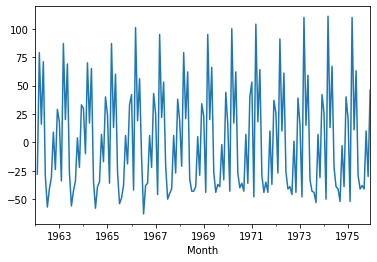

In [24]:
df['Milk First Difference'].plot()

**Seconde différence**

In [25]:
# Il sera parfois nécessaire de faire une deuxième différence 
# C'est juste pour faire le show, on n'avait pas besoin de faire une seconde différence dans notre cas
df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

In [26]:
adf_check(df['Milk Second Difference'].dropna())

Augmented Dickey-Fuller test (DAF):
ADF Test Statistic : -14.327873645603301
p-value : 1.1126989332084581e-26
#Lags Used : 11
Number of Observations Used : 154
Preuves solides contre l'hypothèse nulle, rejeter l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires


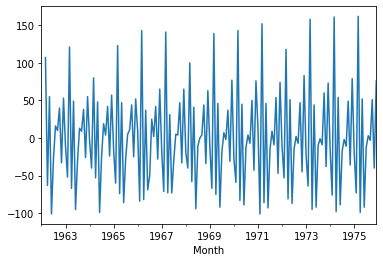

In [27]:
df['Milk Second Difference'].plot()

**Différence Saisonnière**

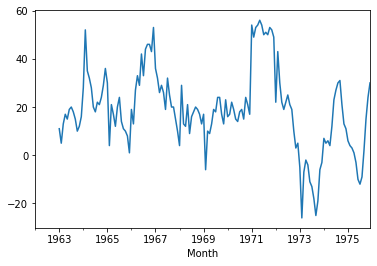

In [28]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
df['Seasonal Difference'].plot()

In [29]:
# Différence Saisonnière non suffisante !
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller test (DAF):
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 


**Première différence saisoniière**

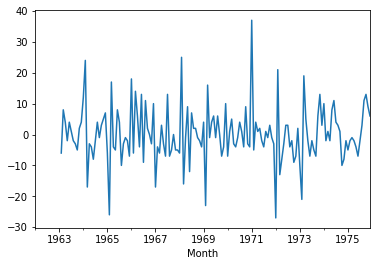

In [30]:
# You can also do seasonal first difference
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [31]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller test (DAF):
ADF Test Statistic : -5.038002274921984
p-value : 1.8654234318788342e-05
#Lags Used : 11
Number of Observations Used : 143
Preuves solides contre l'hypothèse nulle, rejeter l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires


# Graphiques d'Autocorrélation et d'Autocorrélation Partielle

Un tracé d'autocorrélation (aussi connu sous le nom de [Corrélogramme](https://en.wikipedia.org/wiki/Correlogram) ) montre la corrélation de la série avec elle-même, décalée de x unités de temps. L'axe des y est donc la corrélation et l'axe des x est le nombre d'unités de temps de retard.

Imaginez donc de prendre votre série temporelle de longueur T, de la copier, et d'effacer la première observation de la copie #1 et la dernière observation de la copie #2. Vous avez maintenant deux séries de longueur T-1 pour lesquelles vous calculez un coefficient de corrélation. C'est la valeur de l'axe vertical à x=1 dans vos tracés. Il représente la corrélation de la série décalée d'une unité de temps. Vous continuez et faites cela pour tous les décalages possibles x et cela définit le tracé.

Vous exécuterez ces tracés sur vos données différentielles/stationnaires. Il y a beaucoup d'informations intéressantes pour identifier et interpréter ACF (Auto-Correlation Function) et PACF (Partial Auto-Correlation Function) [ici](http://people.duke.edu/~rnau/arimrule.htm) and [ici](https://people.duke.edu/~rnau/411arim3.htm).

### Interprétation de l'autocorrélation

L'interprétation réelle et son rapport avec les modèles ARIMA peuvent devenir un peu compliqués, mais il existe quelques méthodes de base communes que nous pouvons utiliser pour le modèle ARIMA. Notre principale priorité ici est d'essayer de déterminer si nous utiliserons les composantes AR ou MA pour le modèle ARIMA (ou les deux !) ainsi que le nombre de décalages que nous devrions utiliser. En général, vous utiliserez soit AR (Auto-Regressive) soit MA (Moving average), l'utilisation des deux est moins courante.

* Si le graphique d'autocorrélation montre une autocorrélation positive au premier retard (retard-1), alors il suggère d'utiliser les termes AR en relation avec le retard

* Si le graphique d'autocorrélation montre une autocorrélation négative au premier retard, il suggère alors d'utiliser les termes MA.

_____
### <font color='red'> Remarque Importante! </font> 

Ici, nous montrerons le fonctionnement de l'ACF et du PACF sur de multiples ensembles de données différentielles qui ont été rendus stationnaires de différentes façons. En général, il suffit de choisir un seul ensemble de données stationnaires et de continuer jusqu'au bout.

La raison pour laquelle nous en utilisons deux ici est de vous montrer les deux types de comportement typiques que vous observeriez en utilisant l'ACF.
_____

In [32]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

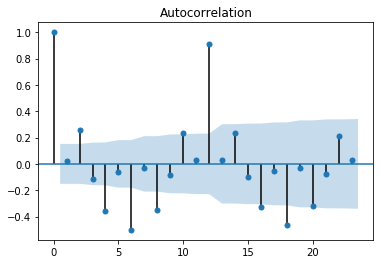

In [33]:
# Dupliquer les graphiques
# Regarde: https://stackoverflow.com/questions/21788593/statsmodels-duplicate-charts
# https://github.com/statsmodels/statsmodels/issues/1265
fig_first = plot_acf(df["Milk First Difference"].dropna())

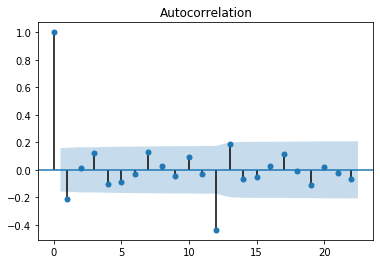

In [34]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

Pandas a également intégré cette fonctionnalité, mais uniquement pour l'ACF, et non pour le PACF. Je recommande donc l'utilisation de statsmodels, car ACF et PACF sont plus au cœur de sa fonctionnalité que de celle de pandas.

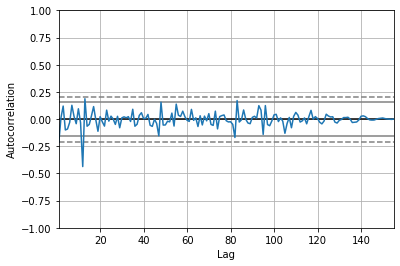

In [35]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Autocorrelation Partielle

En général, une corrélation partielle est une corrélation conditionnelle.

C'est la corrélation entre deux variables sous l'hypothèse que nous connaissons et prenons en compte les valeurs d'un autre ensemble de variables.

Par exemple, considérons un contexte de régression dans lequel y = une variable réponse et x1, x2 et x3 sont des variables prédicteurs.  La corrélation partielle entre y et x3 est la corrélation entre les variables déterminées en tenant compte de la façon dont y et x3 sont liés à x1 et x2.

Formellement, cette relation est définie comme suit

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

Regarde ce [lien](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) pour avoir tous les détails.

Nous pouvons alors tracer cette relation:

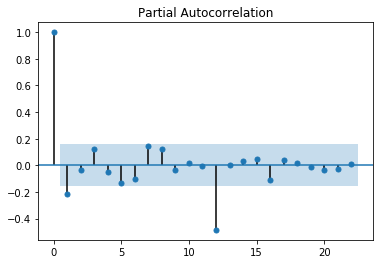

In [36]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

### Interprétation

En général, une chute ou baisse brutale après le décalage "k" suggère d'utiliser un modèle AR-k (Auto-regressive). S'il y a une baisse graduelle, cela suggère un modèle MA (Moving Average).

### Réflexions finales sur l'Autocorrélation et l'Autocorrélation Partielle

* L'identification d'un modèle AR est souvent mieux faite avec le PACF.
    * Pour un modèle de AR, le PACF théorique "s'arrête" au-delà de l'ordre du modèle.  L'expression "s'arrête" signifie qu'en théorie, les autocorrélations partielles sont égales à 0 au-delà de ce point.  Autrement dit, le nombre d'autocorrélations partielles non nulles donne l'ordre du modèle AR.  Par "ordre du modèle", nous entendons le retard le plus extrême de x qui est utilisé comme prédicteur.
    
    
* L'identification d'un modèle MA est souvent mieux faite avec l'ACF plutôt qu'avec le PACF.
    * Pour un modèle MA, le PACF théorique ne s'arrête pas, mais se rétrécit plutôt vers 0 d'une manière ou d'une autre.  Un modèle plus clair pour un modèle MA se trouve dans le PACF.  L'ACF aura des autocorrélations non nulles seulement aux retards impliqués dans le modèle.

_____
### Graphiques définitifs de ACF et PACF

Nous avons exploité un certain nombre de graphiques, alors obtenons rapidement nos graphiques "finaux" de l'ACF et du PACF. Ce sont ceux que nous allons référencer dans le reste du notebook ci-dessous.
_____

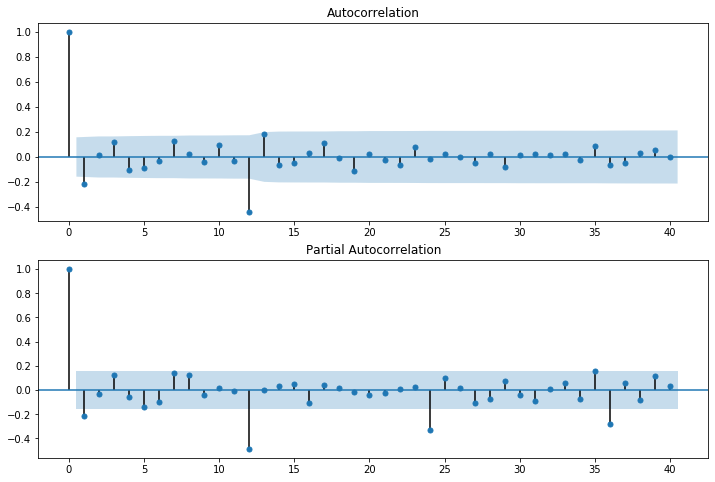

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## En utilisant le modèle ARIMA Saisonnier

Enfin, nous pouvons utiliser notre modèle ARIMA maintenant que nous avons une bonne compréhension de nos données !

In [38]:
# Pour des données non sasonnières
from statsmodels.tsa.arima_model import ARIMA

In [39]:
# Je vous recommande d'y jeter un coup d'oeil !

# 
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes


### Paramètres p, d, q

* p: Le nombre d'observations de retard incluses dans le modèle.
* d: Le nombre de fois que les observations brutes sont différentes, aussi appelé le degré de différence.
* q: La taille de la fenêtre de la moyenne mobile, aussi appelée l'ordre de la moyenne mobile.

In [40]:
# Nou avons des données saisonnières!
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())
# avertissement obtenu en passant dans la fonction statemodels un dataframe dont l'index est un objet datetime pandas

                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 27 Dec 2019   AIC                           1074.131
Time:                                    13:58:54   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

/Users/rod/opt/anaconda3/envs/pyfinance/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


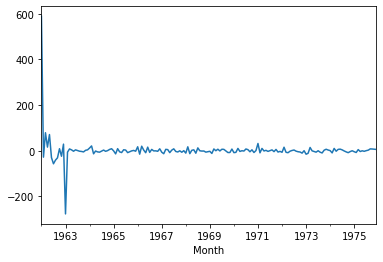

In [41]:
results.resid.plot()

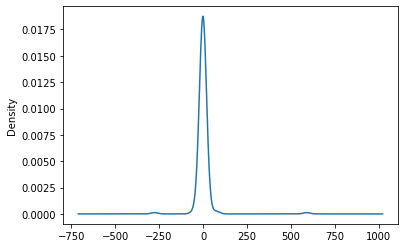

In [42]:
results.resid.plot(kind='kde')

## Prédiction des Valeurs Futures

Nous pouvons avoir une idée de la performance de notre modèle en prédisant simplement pour des valeurs que nous connaissons déjà:

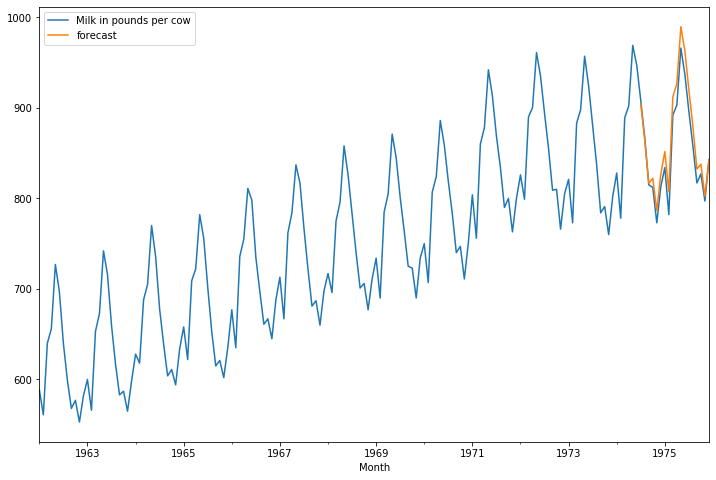

In [43]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

### Prévision
Cela demande plus de temps, alors créons-les avec pandas sur notre dataframe original !

In [44]:
df.tail()

Milk in pounds per cow  Milk First Difference  \
Month                                                       
1975-08-01                   858.0                  -38.0   
1975-09-01                   817.0                  -41.0   
1975-10-01                   827.0                   10.0   
1975-11-01                   797.0                  -30.0   
1975-12-01                   843.0                   46.0   

            Milk Second Difference  Seasonal Difference  \
Month                                                     
1975-08-01                     3.0                 -9.0   
1975-09-01                    -3.0                  2.0   
1975-10-01                    51.0                 15.0   
1975-11-01                   -40.0                 24.0   
1975-12-01                    76.0                 30.0   

            Seasonal First Difference    forecast  
Month                                              
1975-08-01                        3.0  879.668974  
1975-09-01                       11.0  832.328554  
1975-10-01                       13.0  837.722249  
1975-11-01                        9.0  802.452736  
1975-12-01                        6.0  842.499870

In [45]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternatives 
# pd.date_range(df.index[-1],periods=12,freq='M')

In [46]:
from pandas.tseries.offsets import DateOffset

In [47]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]

In [48]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [49]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [50]:
future_df = pd.concat([df,future_dates_df])

In [51]:
future_df.head()

Milk in pounds per cow  Milk First Difference  \
1962-01-01                   589.0                    NaN   
1962-02-01                   561.0                  -28.0   
1962-03-01                   640.0                   79.0   
1962-04-01                   656.0                   16.0   
1962-05-01                   727.0                   71.0   

            Milk Second Difference  Seasonal Difference  \
1962-01-01                     NaN                  NaN   
1962-02-01                     NaN                  NaN   
1962-03-01                   107.0                  NaN   
1962-04-01                   -63.0                  NaN   
1962-05-01                    55.0                  NaN   

            Seasonal First Difference  forecast  
1962-01-01                        NaN       NaN  
1962-02-01                        NaN       NaN  
1962-03-01                        NaN       NaN  
1962-04-01                        NaN       NaN  
1962-05-01                        NaN       NaN

In [52]:
future_df.tail()

Milk in pounds per cow  Milk First Difference  \
1977-07-01                     NaN                    NaN   
1977-08-01                     NaN                    NaN   
1977-09-01                     NaN                    NaN   
1977-10-01                     NaN                    NaN   
1977-11-01                     NaN                    NaN   

            Milk Second Difference  Seasonal Difference  \
1977-07-01                     NaN                  NaN   
1977-08-01                     NaN                  NaN   
1977-09-01                     NaN                  NaN   
1977-10-01                     NaN                  NaN   
1977-11-01                     NaN                  NaN   

            Seasonal First Difference  forecast  
1977-07-01                        NaN       NaN  
1977-08-01                        NaN       NaN  
1977-09-01                        NaN       NaN  
1977-10-01                        NaN       NaN  
1977-11-01                        NaN       NaN

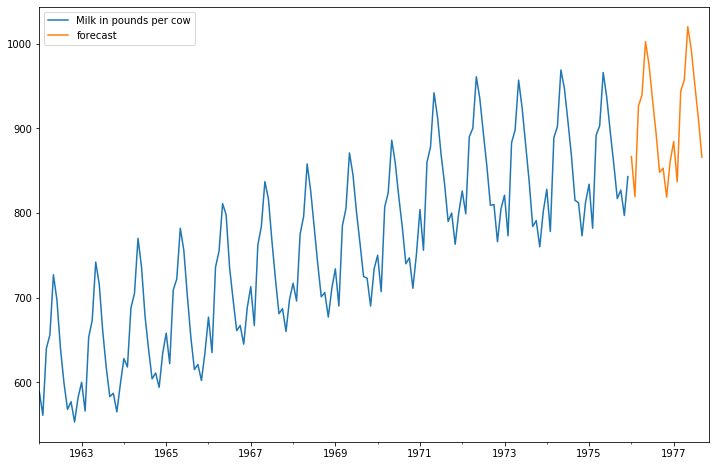

In [53]:
future_df['forecast'] = results.predict(start = 168, end = 188, dynamic= True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8)) 

Pas mal ! Plutôt cool en fait ! J'espère que cela vous a aidé à voir le potentiel des modèles ARIMA, malheureusement beaucoup de données financières ne suivront pas ce genre de comportement, en fait il suivra souvent quelque chose indiquant un mouvement brownien, qu'est ce que c'est ? Et bien allez à la prochaine section vidéo et nous allons le découvrir !

# Bon Travail!